In [3]:
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import scipy
import math

# Loading Datasets

we have loaded the datasets using the hugging face's datasets library, we have observed the TL-DR Datasets split already done into train, test and validation

In [4]:
data_set = load_dataset("trl-lib/tldr")
ds = data_set

In [5]:
train_set = pd.DataFrame(ds["train"])
print(ds.keys())

dict_keys(['train', 'validation', 'test'])


In [6]:
train_size, validation_size, test_size = ds["train"].shape[0], ds["validation"].shape[0], ds["test"].shape[0]
toto = train_size + validation_size + test_size

print("Training Set Size: ", "{:.2f}".format(train_size / toto * 1e2), "%",  " With Records: ", train_size,sep="")
print("Test Set Size: ", "{:.2f}".format(test_size / toto * 1e2), "%",  " With Records: ", test_size,sep="")
print("Validation Set Size: ", "{:.2f}".format(validation_size / toto * 1e2), "%", " With Records: ", validation_size, sep="")

Training Set Size: 89.98% With Records: 116722
Test Set Size: 5.05% With Records: 6553
Validation Set Size: 4.97% With Records: 6447


In [7]:
record = train_set.sample(random_state=56)

In [8]:
print(record.prompt.values[0])

SUBREDDIT: r/AskReddit

TITLE: Is my school extorting me?

POST: I received a parking ticket last Monday from my school.  I had bought a parking pass for the year for school, and due to circumstances beyond my control, the pass found itself locked in my dads truck 20 minutes from home in the opposite direction of school.  

I took my parents car to school (both vehicles are registered with the school on the parking pass) and received a parking ticket for "failing to show a valid permit.".  I appealed the ticket online through the school's website on Tuesday, and I received back a PDF file on Wednesday morning informing me that my appeal was denied (no explanation).  I then emailed the manager Thursday afternoon explaining the situation and asking for an explanation.  

Fast forward to today (Monday).  I still haven't heard back from the manager and if I don't pay the ticket by tonight, the fee will go from $30 to $45.  I'm strapped for cash, but have no choice but to pay it, because I 

In [9]:
print(record.completion.values[0])

 Parking pass registered for 2 vehicles was left at home.  Appeal was denied, nobody has responded. Fee increases tomorrow.


## Task

* Extract Title
* Extract Post

## Extract Title - using Regex

In [10]:
print(record.prompt.str.extract(r'TITLE: ((.|\n)*)\n\nPOST:').values[0][0])

Is my school extorting me?


## Extract Post - using Regex

In [11]:
print(record.prompt.str.extract(r'POST: ((.|\n)*)\nTL;DR:', expand=False).values[0][0])

I received a parking ticket last Monday from my school.  I had bought a parking pass for the year for school, and due to circumstances beyond my control, the pass found itself locked in my dads truck 20 minutes from home in the opposite direction of school.  

I took my parents car to school (both vehicles are registered with the school on the parking pass) and received a parking ticket for "failing to show a valid permit.".  I appealed the ticket online through the school's website on Tuesday, and I received back a PDF file on Wednesday morning informing me that my appeal was denied (no explanation).  I then emailed the manager Thursday afternoon explaining the situation and asking for an explanation.  

Fast forward to today (Monday).  I still haven't heard back from the manager and if I don't pay the ticket by tonight, the fee will go from $30 to $45.  I'm strapped for cash, but have no choice but to pay it, because I can't afford to pay the extra $15.  If I don't pay the ticket at 

In [12]:
print(record.prompt.values[0])

SUBREDDIT: r/AskReddit

TITLE: Is my school extorting me?

POST: I received a parking ticket last Monday from my school.  I had bought a parking pass for the year for school, and due to circumstances beyond my control, the pass found itself locked in my dads truck 20 minutes from home in the opposite direction of school.  

I took my parents car to school (both vehicles are registered with the school on the parking pass) and received a parking ticket for "failing to show a valid permit.".  I appealed the ticket online through the school's website on Tuesday, and I received back a PDF file on Wednesday morning informing me that my appeal was denied (no explanation).  I then emailed the manager Thursday afternoon explaining the situation and asking for an explanation.  

Fast forward to today (Monday).  I still haven't heard back from the manager and if I don't pay the ticket by tonight, the fee will go from $30 to $45.  I'm strapped for cash, but have no choice but to pay it, because I 

## Extracting the Title and the Post from the dataset into seperate columns.

Convert the Dataset to Data Frame and then add columns for post and title

In [13]:
ds = {}
for set_type in data_set.keys():
  ds[set_type] = pd.DataFrame(data_set[set_type])
  ds[set_type]["prompt_post"] = ds[set_type].prompt.str.extract(
      r'POST: ((.|\n)*)\nTL;DR:', expand=False
  ).iloc[:, 0]
  ds[set_type]["prompt_title"] = ds[set_type].prompt.str.extract(
    r'TITLE: ((.|\n)*)\n\nPOST:', expand=False
  ).iloc[:, 0]


In [14]:
train_set = ds["train"]
print(train_set.iloc[0, :])

prompt          SUBREDDIT: r/relationships\n\nTITLE: I (f/22) ...
completion       I still have contact with an old ex's friends...
prompt_post     Not sure if this belongs here but it's worth a...
prompt_title    I (f/22) have to figure out if I want to still...
Name: 0, dtype: object


# Do some basic statistics on the Train set

* Extract the Number of Words in the Prompt
* Extract the Number of Words in the Completion Text
* Extract the Number of Words in the Title


and see if there's any pattern between them

In [29]:
n_words_prompt = []
n_words_completion = []
n_words_title = []
for prompt, completion, title in zip(train_set.prompt, train_set.completion, train_set.prompt_title):
  n_words_prompt.append(len(prompt.split()))
  n_words_completion.append(len(completion.split()))
  n_words_title.append(len(title.split()))

counts = pd.DataFrame(
    {
        "prompt": n_words_prompt,
        "completion": n_words_completion,
        "title": n_words_title,
    }
)


In [30]:
for (task, _counts) in ((
    ("Prompt", n_words_prompt),
    ("Prompt's Completion", n_words_completion),
    ("Prompt's Title", n_words_title),
)):
    stats = scipy.stats.describe(_counts)
    print("Stats for the", task, ":", stats)
    print("STD:", math.sqrt(stats.variance))
    print()

Stats for the Prompt : DescribeResult(nobs=np.int64(116722), minmax=(np.int64(11), np.int64(442)), mean=np.float64(266.40081561316634), variance=np.float64(6029.432066572026), skewness=np.float64(-0.06594287659561676), kurtosis=np.float64(-0.863107830526471))
STD: 77.64941768340589

Stats for the Prompt's Completion : DescribeResult(nobs=np.int64(116722), minmax=(np.int64(7), np.int64(47)), mean=np.float64(27.02162402974589), variance=np.float64(34.70547220250788), skewness=np.float64(0.48083771190937125), kurtosis=np.float64(-0.4477978319286593))
STD: 5.891135052136208

Stats for the Prompt's Title : DescribeResult(nobs=np.int64(116722), minmax=(np.int64(1), np.int64(64)), mean=np.float64(15.78543033875362), variance=np.float64(60.80944391184177), skewness=np.float64(0.9344021016085521), kurtosis=np.float64(1.56691256417108))
STD: 7.7980410304025565



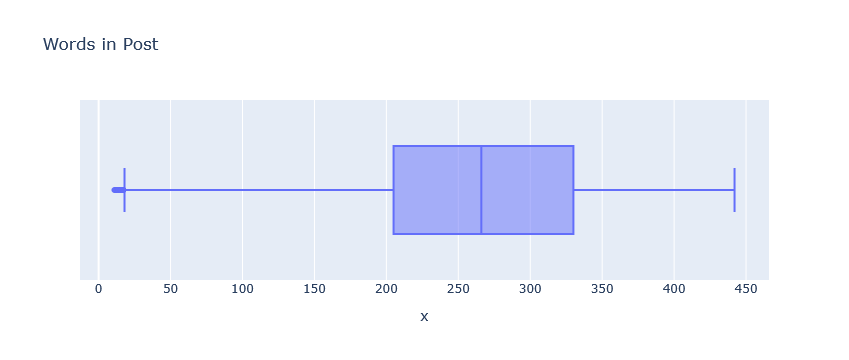

In [33]:
px.box(x=n_words_prompt, title="Words in Post")

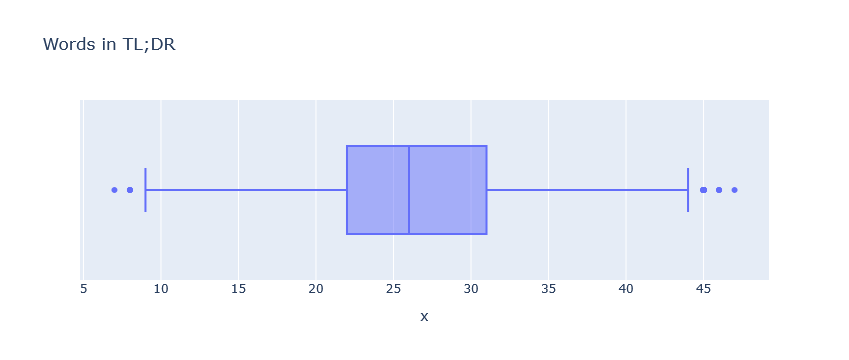

In [32]:
px.box(x=n_words_completion, title="Words in TL;DR")

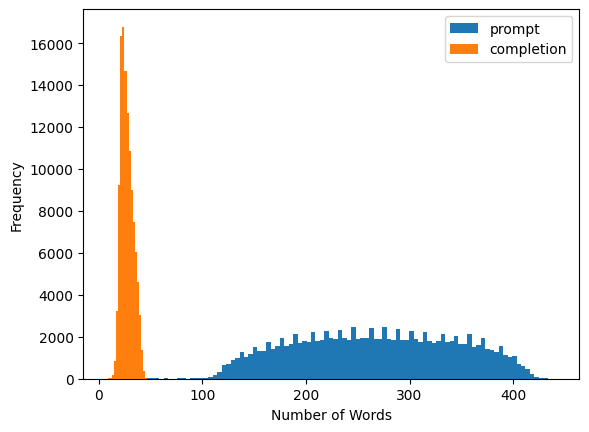

In [18]:
plt.hist(n_words_prompt, bins=100, label="prompt")
plt.hist(n_words_completion, bins = 20, label = "completion")
plt.ylabel("Frequency")
plt.xlabel("Number of Words")
plt.legend()
plt.show()

## Scatter Matrix between prompt, completion and title

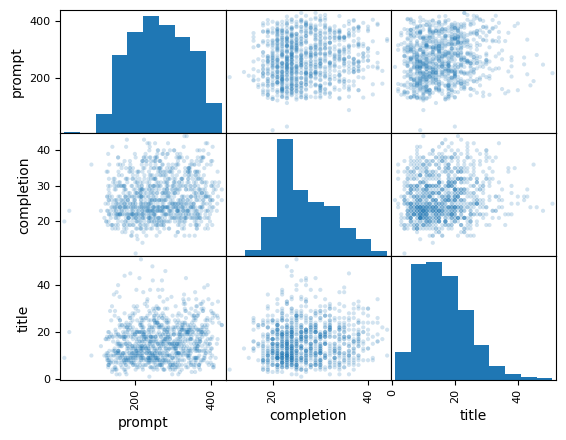

In [19]:
_ = pd.plotting.scatter_matrix(counts.sample(1000), alpha=0.2)

In [20]:
# correlation?
print(scipy.stats.linregress(n_words_prompt, n_words_completion))
print()
print(scipy.stats.linregress(n_words_prompt, n_words_title))
print()
print(scipy.stats.linregress(n_words_title, n_words_completion))

LinregressResult(slope=np.float64(0.009730547772109977), intercept=np.float64(24.429398166892913), rvalue=np.float64(0.12825565218894822), pvalue=np.float64(0.0), stderr=np.float64(0.00022023506420592166), intercept_stderr=np.float64(0.06111226400406934))

LinregressResult(slope=np.float64(0.01007863606800162), intercept=np.float64(13.100473469969714), rvalue=np.float64(0.1003585668082715), pvalue=np.float64(6.267295155289465e-259), stderr=np.float64(0.00029246675883452247), intercept_stderr=np.float64(0.08115558638563623))

LinregressResult(slope=np.float64(0.07443448768270902), intercept=np.float64(25.846643609629673), rvalue=np.float64(0.09852824352011456), pvalue=np.float64(1.3293605950284917e-249), stderr=np.float64(0.0022005057079933455), intercept_stderr=np.float64(0.038743196977776354))


## Conclusions till now

1. Longer Post had longer TLDR's but the change is less as `p-value` is .12
2. Practically, post length or title length does not strongly predict TLDR length.


# Evaluting the Quality of the TL;Dr

we are now seeing the quality of the completion text (tldr) generated from the reddit posts first using the content Overlap metrics.

we would be using the Test Dataset for now as there are many records in the training dataset.

In [27]:
from rouge_score import rouge_scorer
import plotly.express as px
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import torch

In [16]:
test_set = ds["test"].sample(1000)
test_set.columns, test_set.shape

(Index(['prompt', 'completion', 'prompt_post', 'prompt_title'], dtype='object'),
 (1000, 4))

In [17]:
record = test_set.sample(random_state=56)
print(record.prompt.values[0])
print("-------------------------------")
print(record.completion.values[0])

SUBREDDIT: r/relationship_advice

TITLE: (18/m) broke up with my girlfriend(17/f) a month ago, trying to fix it.

POST: i broke up with my girl of 6 months in febuary after we both was feeling really bad. After trying to cut connection I couldn't and we kept o talking. We meet and talked and said we would try again but she wasnt sure, she keept on changing her mind. last weekend I gave her the things we always talked about a date around her city and we then talked again. She told me her feelings had cool down a bit and she wasnt sure what she felt. but we decided to talk and give it some time, not fooling around with other people. She is now away on a trip for 2 weeks in asia and i really miss talk to her. Maybe I should give up but i wont because this is so right. so please guys no tips about letting her go because i wont. I will fight with all my power to get her back. I just don't now exactly what to do at the moment. She is my life, I talk to her all the time and nobody gets me lik

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scorer.score(record.prompt.values[0], record.completion.values[0])

In [29]:
def rouge_score(p, c):
    scores = scorer.score(p, c)
    return pd.Series({
        'rouge1_precision': scores['rouge1'].precision,
        'rouge1_recall': scores['rouge1'].recall,
        'rouge1_fmeasure': scores['rouge1'].fmeasure,
        'rougeL_precision': scores['rougeL'].precision,
        'rougeL_recall': scores['rougeL'].recall,
        'rougeL_fmeasure': scores['rougeL'].fmeasure,
    })

scores_df = test_set[["prompt", "completion"]].apply(
    lambda x: rouge_score(x.iloc[0], x.iloc[1]),
    axis=1
)

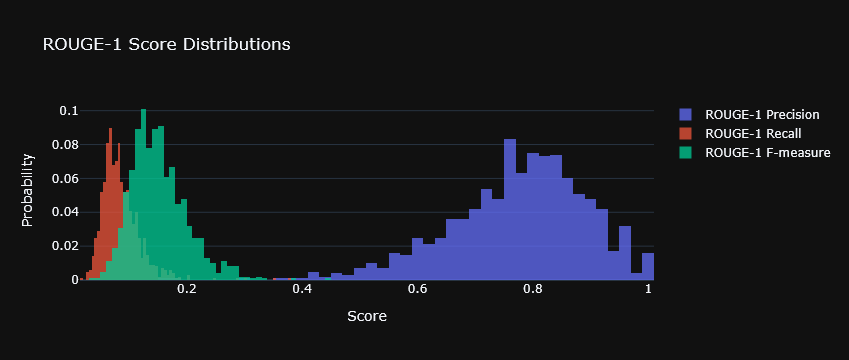

In [30]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=scores_df["rouge1_precision"],
    name="ROUGE-1 Precision",
    histnorm='probability',
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=scores_df["rouge1_recall"],
    name="ROUGE-1 Recall",
    histnorm='probability',
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=scores_df["rouge1_fmeasure"],
    name="ROUGE-1 F-measure",
    histnorm='probability',
    opacity=0.75
))

fig.update_layout(
    barmode='overlay',
    title='ROUGE-1 Score Distributions',
    xaxis_title='Score',
    yaxis_title='Probability',
    template='plotly_dark'
)

fig.show()


## ROUGE-1 F1 Score Formula
---
ROUGE-1 measures unigram overlap between a candidate and reference text.

$$
\text{ROUGE-1}_{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Where:

$$
\text{Precision} = \frac{\text{Overlapping Unigrams}}{\text{Total Unigrams in Candidate}}
$$

$$
\text{Recall} = \frac{\text{Overlapping Unigrams}}{\text{Total Unigrams in Reference}}
$$

## Conclusion based on the Rouge Unigram Score's Precision
---

I believe we can expect the recall and f measures to be less value for the summarizer as the TL;DR is supposed to have the compressed words from the prompt.

but interestly...
we can see mostly ~80% of the words in the tl;dr are also present in the prompt.

That is the TL;DR is mostly extractive, but includes some words (~20%) words which were not from the prompt.

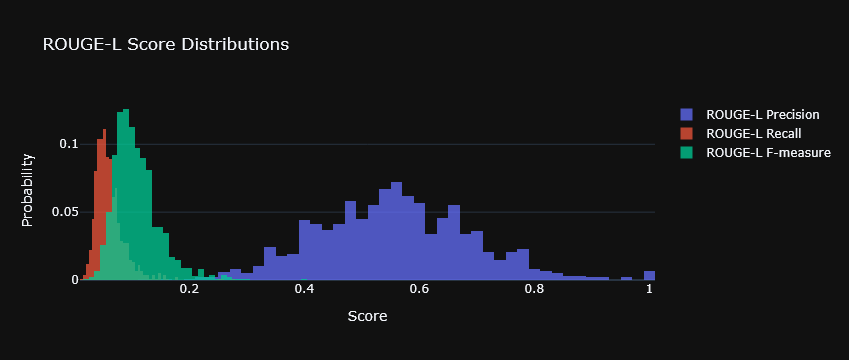

In [31]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=scores_df["rougeL_precision"],
    name="ROUGE-L Precision",
    histnorm='probability',
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=scores_df["rougeL_recall"],
    name="ROUGE-L Recall",
    histnorm='probability',
    opacity=0.75
))

fig.add_trace(go.Histogram(
    x=scores_df["rougeL_fmeasure"],
    name="ROUGE-L F-measure",
    histnorm='probability',
    opacity=0.75
))

fig.update_layout(
    barmode='overlay',
    title='ROUGE-L Score Distributions',
    xaxis_title='Score',
    yaxis_title='Probability',
    template='plotly_dark'
)

fig.show()


## ROUGE-L F1 Score Formula
---
ROUGE-L measures the longest common subsequence (LCS) between a candidate and reference text.

$$
\text{ROUGE-L}_{F1} = \frac{(1 + \beta^2) \cdot \text{Precision} \cdot \text{Recall}}{\text{Recall} + \beta^2 \cdot \text{Precision}}
$$

Where typically \( \beta = \frac{\text{Recall}}{\text{Precision}} \), so F1 balances both.

Definitions:

$$
\text{Precision} = \frac{\text{LCS}(X, Y)}{\text{Length of Candidate}}
$$

$$
\text{Recall} = \frac{\text{LCS}(X, Y)}{\text{Length of Reference}}
$$

Here, $\text{LCS}(X, Y)$ is the length of the longest common subsequence between the reference $X$ and the candidate $Y$.

## Conclusion based on the RougeL_Precision
---

though the TL;DR seems to have most of the words coming from the prompt but it does not seem to be copying specific part of the sequence of the prompt only (which is expected from good sumarizer) so it is generating TL;DR of the post though it uses most of the words from the prompt but the ordering and paraphrasing is not copied exactly.


# Evaluting with Model based Metrics

we are now seeing how does the completion makes sense semantically.

In [59]:
print(record.prompt.values[0])  # we are going to check if the value here makes sense

SUBREDDIT: r/relationships

TITLE: My girlfriend (20/F) broke up with me(22/M) because she turned lesbian

POST: So, after 5 months she figured out she likes girls . She's been thinking about that for a long time and after meeting a certain girl, she decided she is more happy with girls rather than boys.

Now, the problem is that I lost a soul mate. She is the first to understand my problems, first that I opened up to, not just as a girlfriend, but as a person. She knows more about me than my parents. All that I had planned is now lost, I am lost, I don't know what to do and how to deal with this. I am too emotional to just forget some one that I loved with all of my heart, and even tho she did all of this to me, I still love her and care for her.
Reddit, what should I do? How do I get over this? I've taken some pills to calm myself down, but I don't want to be on pills...

TL;DR:


In [20]:
print(record.completion.values[0])  # we are going to check if the value here makes sense

 GF breaks up with me because she decided she likes girls, broke my heart, lost my soul mate. Need help to get over it, if possible.


In [58]:
from bert_score import score
score([record.prompt.values[0]], [record.completion.values[0]], lang='en',
    model_type="roberta-large",
    rescale_with_baseline=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([-0.0732]), tensor([0.4711]), tensor([0.1858]))

In [54]:
p_s = test_set.prompt.values.tolist()
c_s = test_set.completion.values.tolist()

P, R, F1 = score(
    p_s,
    c_s,
    lang="en",
    model_type="roberta-large",
    rescale_with_baseline=True
)

df_bert = pd.DataFrame({
    "prompt": p_s,
    "completion": c_s,
    "P": P.tolist(),
    "R": R.tolist(),
    "F1": F1.tolist()
})

C:\Users\saiha\Documents\Hosted Experiments\NLPProject\.venv\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


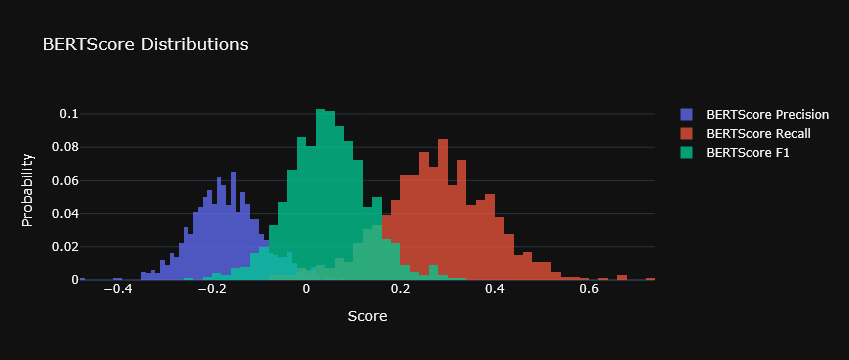

In [56]:
import plotly.graph_objects as go

fig = go.Figure()

# Precision
fig.add_trace(go.Histogram(
    x=df_bert["P"],
    name="BERTScore Precision",
    histnorm='probability',
    opacity=0.75
))

# Recall
fig.add_trace(go.Histogram(
    x=df_bert["R"],
    name="BERTScore Recall",
    histnorm='probability',
    opacity=0.75
))

# F1
fig.add_trace(go.Histogram(
    x=df_bert["F1"],
    name="BERTScore F1",
    histnorm='probability',
    opacity=0.75
))

fig.update_layout(
    barmode='overlay',
    title='BERTScore Distributions',
    xaxis_title='Score',
    yaxis_title='Probability',
    template='plotly_dark'
)

fig.show()


## Sentence Embeddings

we will convert the prompts and completion to the sentence embeddings and see how similar they are
$$
\text{cosine\_similarity} = \frac{A \cdot B}{\|A\| \cdot \|B\|}
$$

all-MiniLM-L6-v2 is a lightweight SentenceTransformer model

In [18]:
p_s = test_set.prompt.values.tolist()
c_s = test_set.completion.values.tolist()

model = SentenceTransformer("all-MiniLM-L6-v2")  

# sentence embeddings
batch_size = 64  
prompt_embeddings = model.encode(p_s, batch_size=batch_size, convert_to_tensor=True, show_progress_bar=True)
completion_embeddings = model.encode(c_s, batch_size=batch_size, convert_to_tensor=True, show_progress_bar=True)

# Compute cosine similarity for each pair
cos_scores = util.cos_sim(prompt_embeddings, completion_embeddings).diagonal()  # shape: [len(p_s)]

# Optional: convert similarity to extractive/abstractive label
def classify_f1(sim):
    if sim >= 0.8:
        return "extractive"
    elif sim >= 0.5:
        return "mixed"
    else:
        return "abstractive"

labels = [classify_f1(score.item()) for score in cos_scores]

# Build dataframe
df_fast = pd.DataFrame({
    "prompt": p_s,
    "completion": c_s,
    "cosine_similarity": cos_scores.cpu().tolist(),
    "label": labels
})

df_fast.head()


Batches: 100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.62it/s]


,prompt,completion,cosine_similarity,label
0,SUBREDDIT: r/relationships\n\nTITLE: Me [27M] ...,Had a good friend that was engaged and about ...,0.482570,abstractive
1,SUBREDDIT: r/relationship_advice\n\nTITLE: Boy...,"Boyfriend got a new job, constantly telling m...",0.594483,mixed
2,SUBREDDIT: r/relationships\n\nTITLE: I [18F] a...,I have no friends and I'm worried that my boy...,0.408534,abstractive
3,SUBREDDIT: r/relationships\n\nTITLE: Me [21 M]...,"Girlfriend was raped, was making progress, bu...",0.678213,mixed
4,SUBREDDIT: r/tifu\n\nTITLE: TIFU by bleeding a...,"got pervy, got hit. so ashamed and now i'm ju...",0.330260,abstractive


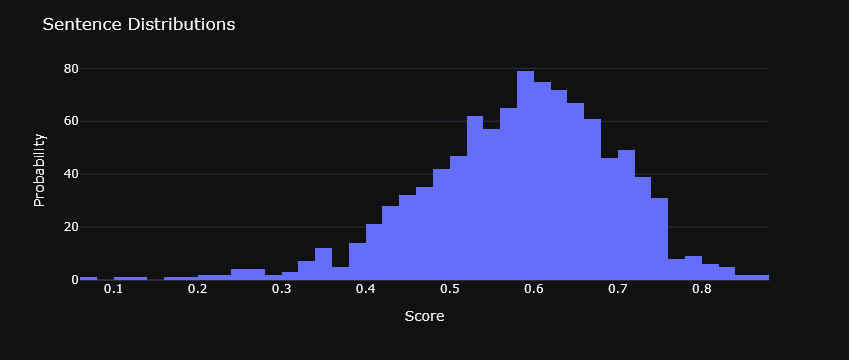

In [25]:
fig = px.histogram(df_fast, x="cosine_similarity")
fig.update_layout(
    title='Sentence Distributions',
    xaxis_title='Score',
    yaxis_title='Probability',
    template='plotly_dark'
)

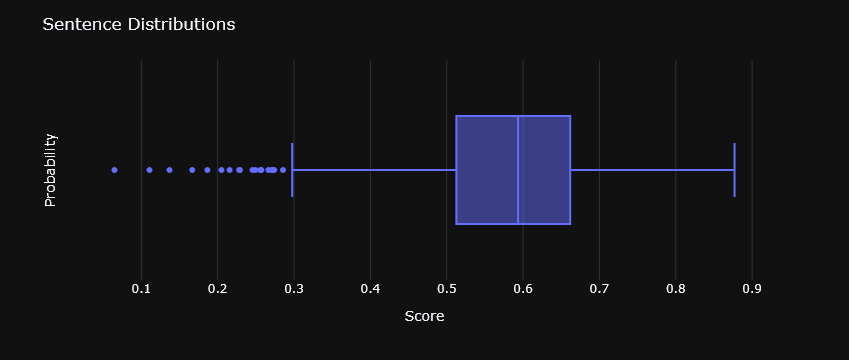

In [26]:
fig = px.box(df_fast, x="cosine_similarity")
fig.update_layout(
    title='Sentence Distributions',
    xaxis_title='Score',
    yaxis_title='Probability',
    template='plotly_dark'
)

## Conclusion

since the prompts and completion are ~60% same which means the TL;DR is abstractive and not exactly that of the prompt.